In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from scipy.stats import zscore, chi2_contingency, ttest_ind
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import xgboost as xgb 
import joblib


# **DỮ LIỆU BAN ĐẦU**

In [2]:
# Đọc dữ liệu
df = pd.read_csv("heart_disease.csv",sep=',')

# Phân loại cột
numeric_columns = ['Age', 'Blood Pressure', 'Cholesterol Level', 'BMI', 'Sleep Hours', 
                   'Triglyceride Level', 'Fasting Blood Sugar', 'CRP Level', 'Homocysteine Level']

categorical_columns = ['Gender', 'Exercise Habits', 'Smoking', 'Family Heart Disease', 
                       'Diabetes', 'High Blood Pressure', 'Low HDL Cholesterol', 
                       'High LDL Cholesterol', 'Alcohol Consumption', 'Stress Level', 
                       'Sugar Consumption', 'Heart Disease Status']

ordinal_columns = ['Exercise Habits',  'Alcohol Consumption', 
                       'Stress Level',  'Sugar Consumption',]

nominal_columns = ['Gender','Smoking','Family Heart Disease','Diabetes','High Blood Pressure', 
                    'High LDL Cholesterol','Low HDL Cholesterol', 'Heart Disease Status']
#Xóa duplicate
df = df.drop_duplicates()

print("Dữ liệu ban đầu:",)
print(df.head())



Dữ liệu ban đầu:
    Age  Gender  Blood Pressure  Cholesterol Level Exercise Habits Smoking  \
0  56.0    Male           153.0              155.0            High     Yes   
1  69.0  Female           146.0              286.0            High      No   
2  46.0    Male           126.0              216.0             Low      No   
3  32.0  Female           122.0              293.0            High     Yes   
4  60.0    Male           166.0              242.0             Low     Yes   

  Family Heart Disease Diabetes        BMI High Blood Pressure  ...  \
0                  Yes       No  24.991591                 Yes  ...   
1                  Yes      Yes  25.221799                  No  ...   
2                   No       No  29.855447                  No  ...   
3                  Yes       No  24.130477                 Yes  ...   
4                  Yes      Yes  20.486289                 Yes  ...   

  High LDL Cholesterol Alcohol Consumption Stress Level Sleep Hours  \
0               

### **Check thông tin các cột**

In [ ]:
df.columns
df.info()

### **Thống kê giá trị các cột số**

In [ ]:
# Kiểm tra các cột số
for col in numeric_columns:
    print(f"Cột số: {col}")
    print(f"  - Giá trị lớn nhất: {df[col].max()}")
    print(f"  - Giá trị nhỏ nhất: {df[col].min()}")
    print(f"  - Giá trị trung bình: {df[col].mean():.2f}")
    print(f"  - Phương sai: {df[col].var():.2f}")
    print(f"  - Độ lệch chuẩn: {df[col].std():.2f}")
    mode_value = df[col].mode().values[0]  # Lấy giá trị mode
    mode_count = (df[col] == mode_value).sum()  # Đếm số lần xuất hiện của mode
    print(f"  - Mode: {mode_value}")
    print(f"  - Số lần xuất hiện của mode: {mode_count}")
    print("-" * 50)


### **Thống kê giá trị các cột phân loại**

In [ ]:
for col in ordinal_columns:
    print(f"Cột phân loại có thứ tự: {col}")
    print(df[col].value_counts())
    print("-" * 50)

for col in nominal_columns:
    print(f"Cột phân loại không có thứ tự: {col}")
    print(df[col].value_counts())
    print("-" * 50)

# **TIỀN XỬ LÝ DỮ LIỆU**

### **Chuẩn hóa dữ liệu, đưa dữ liệu về 1 thang đo MinMaxScaler**

In [3]:
# Xử lý cột số: Chuẩn hóa bằng MinMaxScaler
scaler_minmax = MinMaxScaler()
data_numeric_scaled = pd.DataFrame(scaler_minmax.fit_transform(df[numeric_columns]), 
                                   columns=numeric_columns, index=df.index)

# Xử lý cột danh nghĩa
# Cột Gender: Male → 0, Female → 1, giữ NaN
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

# Các cột danh nghĩa khác: Yes → 1, No → 0, giữ NaN
for col in nominal_columns:
    if col != 'Gender':
        df[col] = df[col].map({'Yes': 1, 'No': 0})

# Xử lý cột ordinal: Low → 0, Medium → 0.5, High → 1, giữ NaN
ordinal_mapping = {'Low': 0, 'Medium': 0.5, 'High': 1}
for col in ordinal_columns:
    df[col] = df[col].map(ordinal_mapping)

# Kiểm tra giá trị duy nhất sau khi mã hóa
for col in nominal_columns + ordinal_columns:
    print(f"Giá trị duy nhất trong {col} (sau mã hóa):", df[col].unique())
df_normalized = pd.concat([data_numeric_scaled, df[nominal_columns], df[ordinal_columns]], axis=1)
print("\nDữ liệu sau khi chuẩn hóa:\n")
print(df_normalized.head(10))
print("Số cột trong df_normalized:", df_normalized.shape[1])
print("Tên cột trong df_normalized:", df_normalized.columns.tolist())

Giá trị duy nhất trong Gender (sau mã hóa): [ 0.  1. nan]
Giá trị duy nhất trong Smoking (sau mã hóa): [ 1.  0. nan]
Giá trị duy nhất trong Family Heart Disease (sau mã hóa): [ 1.  0. nan]
Giá trị duy nhất trong Diabetes (sau mã hóa): [ 0.  1. nan]
Giá trị duy nhất trong High Blood Pressure (sau mã hóa): [ 1.  0. nan]
Giá trị duy nhất trong High LDL Cholesterol (sau mã hóa): [ 0.  1. nan]
Giá trị duy nhất trong Low HDL Cholesterol (sau mã hóa): [ 1.  0. nan]
Giá trị duy nhất trong Heart Disease Status (sau mã hóa): [0 1]
Giá trị duy nhất trong Exercise Habits (sau mã hóa): [1.  0.  0.5 nan]
Giá trị duy nhất trong Alcohol Consumption (sau mã hóa): [1.  0.5 0.  nan]
Giá trị duy nhất trong Stress Level (sau mã hóa): [0.5 1.  0.  nan]
Giá trị duy nhất trong Sugar Consumption (sau mã hóa): [0.5 0.  1.  nan]

Dữ liệu sau khi chuẩn hóa:

        Age  Blood Pressure  Cholesterol Level       BMI  Sleep Hours  \
0  0.612903        0.550000           0.033333  0.317756     0.605503   
1  0.822581

### **Áp dụng KNN để điền giá trị thiếu**

In [4]:
imputer = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(imputer.fit_transform(df_normalized), columns=df_normalized.columns)
#Xử lý giá trị cho các cột phân loại
df_imputed[nominal_columns] = df_imputed[nominal_columns].round().astype(int)

for col in ordinal_columns:
    df_imputed[col] = df_imputed[col].apply(
        lambda x: 0 if abs(x - 0) <= 0.25 else 0.5 if abs(x - 0.5) <= 0.25 else 1
    )
    
print("\nDataset sau khi điền giá trị thiếu:")
df_imputed.head(20)


Dataset sau khi điền giá trị thiếu:


,Age,Blood Pressure,Cholesterol Level,BMI,Sleep Hours,Triglyceride Level,Fasting Blood Sugar,CRP Level,Homocysteine Level,Gender,...,Family Heart Disease,Diabetes,High Blood Pressure,High LDL Cholesterol,Low HDL Cholesterol,Heart Disease Status,Exercise Habits,Alcohol Consumption,Stress Level,Sugar Consumption
0,0.612903,0.550000,0.033333,0.317756,0.605503,0.806667,0.4950,0.864751,0.492507,0,...,1,0,1,0,1,0,1.0,1.0,0.5,0.5
1,0.822581,0.433333,0.906667,0.328222,0.790657,0.110000,0.9625,0.623722,0.953319,1,...,1,1,0,0,1,0,1.0,0.5,1.0,0.5
2,0.451613,0.100000,0.440000,0.538899,0.073314,0.976667,0.1500,0.847452,0.415412,0,...,0,0,0,1,1,0,0.0,0.0,0.0,0.0
3,0.225806,0.033333,0.953333,0.278604,0.208156,0.643333,0.1750,0.834058,0.064120,1,...,1,0,1,1,0,0,1.0,0.0,1.0,1.0
4,0.677419,0.766667,0.613333,0.112914,0.505116,0.543333,0.9250,0.692144,0.210260,0,...,1,1,1,0,0,0,0.0,0.0,1.0,1.0
5,0.112903,0.533333,0.713333,0.461116,0.250739,0.086667,0.1375,0.286387,0.387747,0,...,0,0,0,0,0,0,0.0,0.0,0.5,0.0
6,0.967742,0.016667,0.166667,0.001796,0.873479,0.023333,0.0625,0.772294,0.977360,1,...,1,1,0,0,1,0,1.0,0.5,0.5,0.5
7,0.322581,0.683333,0.246667,0.760833,0.640137,0.426667,0.3875,0.328526,0.809822,1,...,1,1,0,0,0,0,0.0,0.0,0.5,1.0
8,0.612903,0.250000,0.940000,0.749758,0.490186,0.723333,0.2875,0.341174,0.070065,1,...,1,1,1,1,0,0,0.0,1.0,0.0,1.0
9,0.919355,0.400000,0.680000,0.551935,0.000343,0.330000,0.2000,0.667095,0.173622,0,...,1,0,0,1,0,0,0.0,0.0,0.5,1.0


### **Xóa duplicate và xử lý outlier**

In [5]:
duplicates = df_imputed.duplicated().sum()
print(f"\nSố dòng trùng lặp: {duplicates}")
df_no_duplicat_no_outlier = df_imputed.drop_duplicates()

df_zscore = df_no_duplicat_no_outlier[numeric_columns].apply(zscore)
outliers = (df_zscore > 3) | (df_zscore < -3)

if outliers.any().any():
    print("\nDữ liệu chứa các outliers (Z-score > 3 hoặc < -3):")
    outlier_rows = df_no_duplicat_no_outlier[outliers.any(axis=1)]
    print(outlier_rows.head(5))
    print("\nXóa các dòng chứa outlier:")
    df_no_outliers = df_no_duplicat_no_outlier[~outliers.any(axis=1)]
    print(f"Số dòng sau khi xóa outlier: {len(df_no_outliers)}")
    df_discretized = df_no_outliers.copy()
else:
    print("\nKhông có outliers trong dataset.")
    df_discretized = df_no_duplicat_no_outlier.copy()



Số dòng trùng lặp: 0

Không có outliers trong dataset.


### **Trích xuất đặc trưng**

In [6]:
# Chi-Square Test giữa biến phân loại với nhãn.
categorical_features = [col for col in categorical_columns if col != 'Heart Disease Status']
chi2_scores = []
for col in categorical_features:
    contingency_table = pd.crosstab(df_no_duplicat_no_outlier[col], df_no_duplicat_no_outlier['Heart Disease Status'])
    if contingency_table.size > 0:  # Kiểm tra bảng không rỗng
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        chi2_scores.append((col, chi2, p))

chi2_scores.sort(key=lambda x: x[1], reverse=True)
print("\nTop các cột phân loại có Chi2 cao nhất với Heart Disease Status:")
for i, (col, chi2, p) in enumerate(chi2_scores[:13], 1):
    print(f"{i}. {col}: Chi2 = {chi2:.2f}, p-value = {p:.4f}")


# T-test
ttest_selected = []
for feature in numeric_columns:
    group_0 = df_no_duplicat_no_outlier[df_no_duplicat_no_outlier['Heart Disease Status'] == 0][feature]
    group_1 = df_no_duplicat_no_outlier[df_no_duplicat_no_outlier['Heart Disease Status'] == 1][feature]
    t_stat, p_value = ttest_ind(group_0, group_1)
    print(f"T-test for {feature}: T-stat = {t_stat:.4f}, p-value = {p_value:.4f}")
    if p_value < 0.05:
        ttest_selected.append(feature)

# Random Forest
X = df_no_duplicat_no_outlier.drop(columns=['Heart Disease Status'])
y = df_no_duplicat_no_outlier['Heart Disease Status']
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X, y)
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': rf_model.feature_importances_})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print("\nTop các thuộc tính quan trọng nhất theo Random Forest:")
print(importance_df.head(13))
importance_df.to_csv('feature_importance_random_forest.csv', index=False)

# Kết hợp chọn cột
chi2_selected = [col for col, chi2, p in chi2_scores if p < 0.05]
rf_selected = importance_df[importance_df['Importance'] > 0.05]['Feature'].tolist()
selected_columns = list(set(chi2_selected + ttest_selected + rf_selected))
print(f"\nTổng hợp các cột được chọn: {selected_columns}")

df_reduced = df_no_duplicat_no_outlier[selected_columns + ['Heart Disease Status']]
print(f"Số cột sau khi giảm: {len(df_reduced.columns)}")
print("\nDataset sau khi giảm cột (5 dòng đầu):")
df_reduced.head()


Top các cột phân loại có Chi2 cao nhất với Heart Disease Status:
1. Stress Level: Chi2 = 7.52, p-value = 0.0233
2. Alcohol Consumption: Chi2 = 2.96, p-value = 0.2277
3. Gender: Chi2 = 2.58, p-value = 0.1085
4. Sugar Consumption: Chi2 = 1.30, p-value = 0.5230
5. High LDL Cholesterol: Chi2 = 0.75, p-value = 0.3870
6. Family Heart Disease: Chi2 = 0.50, p-value = 0.4808
7. Exercise Habits: Chi2 = 0.28, p-value = 0.8695
8. Low HDL Cholesterol: Chi2 = 0.27, p-value = 0.6066
9. Smoking: Chi2 = 0.10, p-value = 0.7527
10. High Blood Pressure: Chi2 = 0.05, p-value = 0.8298
11. Diabetes: Chi2 = 0.03, p-value = 0.8532
T-test for Age: T-stat = 0.9338, p-value = 0.3504
T-test for Blood Pressure: T-stat = 1.3800, p-value = 0.1676
T-test for Cholesterol Level: T-stat = -0.2500, p-value = 0.8026
T-test for BMI: T-stat = -1.9728, p-value = 0.0485
T-test for Sleep Hours: T-stat = 0.3970, p-value = 0.6914
T-test for Triglyceride Level: T-stat = -0.2783, p-value = 0.7808
T-test for Fasting Blood Sugar: T-

,Stress Level,BMI,CRP Level,Cholesterol Level,Fasting Blood Sugar,Sleep Hours,Homocysteine Level,Age,Triglyceride Level,Blood Pressure,Heart Disease Status
0,0.5,0.317756,0.864751,0.033333,0.4950,0.605503,0.492507,0.612903,0.806667,0.550000,0
1,1.0,0.328222,0.623722,0.906667,0.9625,0.790657,0.953319,0.822581,0.110000,0.433333,0
2,0.0,0.538899,0.847452,0.440000,0.1500,0.073314,0.415412,0.451613,0.976667,0.100000,0
3,1.0,0.278604,0.834058,0.953333,0.1750,0.208156,0.064120,0.225806,0.643333,0.033333,0
4,1.0,0.112914,0.692144,0.613333,0.9250,0.505116,0.210260,0.677419,0.543333,0.766667,0


### **Giải chuẩn hóa**

In [7]:
ranges = {
    'Age': (18.0, 80.0),
    'Sleep Hours': (4.000605495703501, 9.999952253817796),
    'BMI': (18.00283694367505, 39.99695379658124),
    'Homocysteine Level': (5.000236488356111, 19.99903699208996),
    'Cholesterol Level': (150.0, 300.0),
    'Blood Pressure': (120.0, 180.0),
    'Triglyceride Level': (100.0, 400.0),
    'CRP Level': (0.0036467123625, 14.997086730710286),
    'Fasting Blood Sugar': (80.0, 160.0)
}


df_imputed_copy = df_imputed.copy()
for col in numeric_columns:
    min_val, max_val = ranges[col]
    df_imputed_copy.loc[:, col] = df_imputed_copy[col] * (max_val - min_val) + min_val

df_reduced_copy = df_reduced.copy()
numeric_columns_reduced = [
    'Age', 'Sleep Hours', 'BMI', 'Homocysteine Level', 'Cholesterol Level',
    'Blood Pressure', 'Triglyceride Level', 'CRP Level', 'Fasting Blood Sugar'
]
for col in numeric_columns_reduced:
    min_val, max_val = ranges[col]
    df_reduced_copy.loc[:, col] = df_reduced_copy[col] * (max_val - min_val) + min_val


In [8]:
df_imputed_copy.head()

,Age,Blood Pressure,Cholesterol Level,BMI,Sleep Hours,Triglyceride Level,Fasting Blood Sugar,CRP Level,Homocysteine Level,Gender,...,Family Heart Disease,Diabetes,High Blood Pressure,High LDL Cholesterol,Low HDL Cholesterol,Heart Disease Status,Exercise Habits,Alcohol Consumption,Stress Level,Sugar Consumption
0,56.0,153.0,155.0,24.991591,7.633228,342.0,119.6,12.969246,12.387250,0,...,1,0,1,0,1,0,1.0,1.0,0.5,0.5
1,69.0,146.0,286.0,25.221799,8.744034,133.0,157.0,9.355389,19.298875,1,...,1,1,0,0,1,0,1.0,0.5,1.0,0.5
2,46.0,126.0,216.0,29.855447,4.440440,393.0,92.0,12.709873,11.230926,0,...,0,0,0,1,1,0,0.0,0.0,0.0,0.0
3,32.0,122.0,293.0,24.130477,5.249405,293.0,94.0,12.509046,5.961958,1,...,1,0,1,1,0,0,1.0,0.0,1.0,1.0
4,60.0,166.0,242.0,20.486289,7.030971,263.0,154.0,10.381259,8.153887,0,...,1,1,1,0,0,0,0.0,0.0,1.0,1.0


In [9]:
df_reduced_copy.tail()

,Stress Level,BMI,CRP Level,Cholesterol Level,Fasting Blood Sugar,Sleep Hours,Homocysteine Level,Age,Triglyceride Level,Blood Pressure,Heart Disease Status
9995,1.0,18.788791,3.588814,243.0,133.0,6.834954,19.132004,25.0,343.0,136.0,1
9996,1.0,31.856801,2.658267,154.0,83.0,8.247784,9.715709,38.0,377.0,172.0,1
9997,0.0,26.899911,4.408867,201.0,88.0,4.436762,9.492429,73.0,248.0,152.0,1
9998,1.0,34.964026,7.215634,299.0,153.0,8.526329,11.873486,23.0,113.0,142.0,1
9999,0.5,25.111295,14.387810,193.0,149.0,5.659394,6.208531,38.0,121.0,128.0,1


# **HUẤN LUYỆN MÔ HÌNH**

### Huấn luyện mô hình với dữ liệu chưa được trích xuất so sánh với mô hình với dữ liệu đã được trích xuất

In [10]:

# Chuẩn bị dữ liệu từ df_imputed
X_full = df_imputed.drop(columns=['Heart Disease Status'])
y_full = df_imputed['Heart Disease Status']
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X_full, y_full, test_size=0.3, random_state=42, stratify=y_full
)

# Áp dụng SMOTE cho tập huấn luyện
smote = SMOTE(random_state=42)
X_train_full_smote, y_train_full_smote = smote.fit_resample(X_train_full, y_train_full)

# Chuẩn bị dữ liệu từ df_reduced
X_reduced = df_reduced.drop(columns=['Heart Disease Status'])
y_reduced = df_reduced['Heart Disease Status']
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(
    X_reduced, y_reduced, test_size=0.3, random_state=42, stratify=y_reduced
)

# Áp dụng SMOTE
X_train_reduced_smote, y_train_reduced_smote = smote.fit_resample(X_train_reduced, y_train_reduced)

# Kiểm tra dữ liệu
print("Số cột trong df_final:", X_full.shape[1])
print("Số cột trong df_reduced:", X_reduced.shape[1])

Số cột trong df_final: 20
Số cột trong df_reduced: 10


In [11]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import time

# Khởi tạo mô hình
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Thêm mô hình
models = {
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'SVM': SVC(random_state=42, probability=True)  # cần `probability=True` để dùng predict_proba
}


# Hàm đánh giá mô hình
def evaluate_model(model, X_train, y_train, X_test, y_test):
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    return {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-score': f1_score(y_test, y_pred),
        'AUC-ROC': roc_auc_score(y_test, y_prob),
        'Training Time (s)': training_time
    }

# So sánh mô hình
results = []
for name, model in models.items():
    # Đánh giá trên df_final
    print(f"\nĐánh giá {name} trên df_imputed...")
    result_full = evaluate_model(model, X_train_full_smote, y_train_full_smote, X_test_full, y_test_full)
    result_full['Model'] = name
    result_full['Dataset'] = 'df_final'
    results.append(result_full)

    # Đánh giá trên df_reduced
    print(f"Đánh giá {name} trên df_reduced...")
    result_reduced = evaluate_model(model, X_train_reduced_smote, y_train_reduced_smote, X_test_reduced, y_test_reduced)
    result_reduced['Model'] = name
    result_reduced['Dataset'] = 'df_reduced'
    results.append(result_reduced)

# Hiển thị kết quả
results_df = pd.DataFrame(results)
print("\nKết quả so sánh mô hình:")
print(results_df[['Model', 'Dataset', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC-ROC', 'Training Time (s)']])

# Lưu kết quả
results_df.to_csv('model_comparison.csv', index=False)


Đánh giá Random Forest trên df_imputed...
Đánh giá Random Forest trên df_reduced...

Đánh giá XGBoost trên df_imputed...
Đánh giá XGBoost trên df_reduced...

Đánh giá Logistic Regression trên df_imputed...
Đánh giá Logistic Regression trên df_reduced...

Đánh giá KNN trên df_imputed...
Đánh giá KNN trên df_reduced...

Đánh giá SVM trên df_imputed...
Đánh giá SVM trên df_reduced...

Kết quả so sánh mô hình:
                 Model     Dataset  Accuracy  Precision    Recall  F1-score  \
0        Random Forest    df_final  0.789000   0.188679  0.016667  0.030628   
1        Random Forest  df_reduced  0.710000   0.215190  0.170000  0.189944   
2              XGBoost    df_final  0.767667   0.187097  0.048333  0.076821   
3              XGBoost  df_reduced  0.690333   0.200364  0.183333  0.191471   
4  Logistic Regression    df_final  0.513000   0.192719  0.450000  0.269865   
5  Logistic Regression  df_reduced  0.502000   0.191298  0.461667  0.270508   
6                  KNN    df_final  

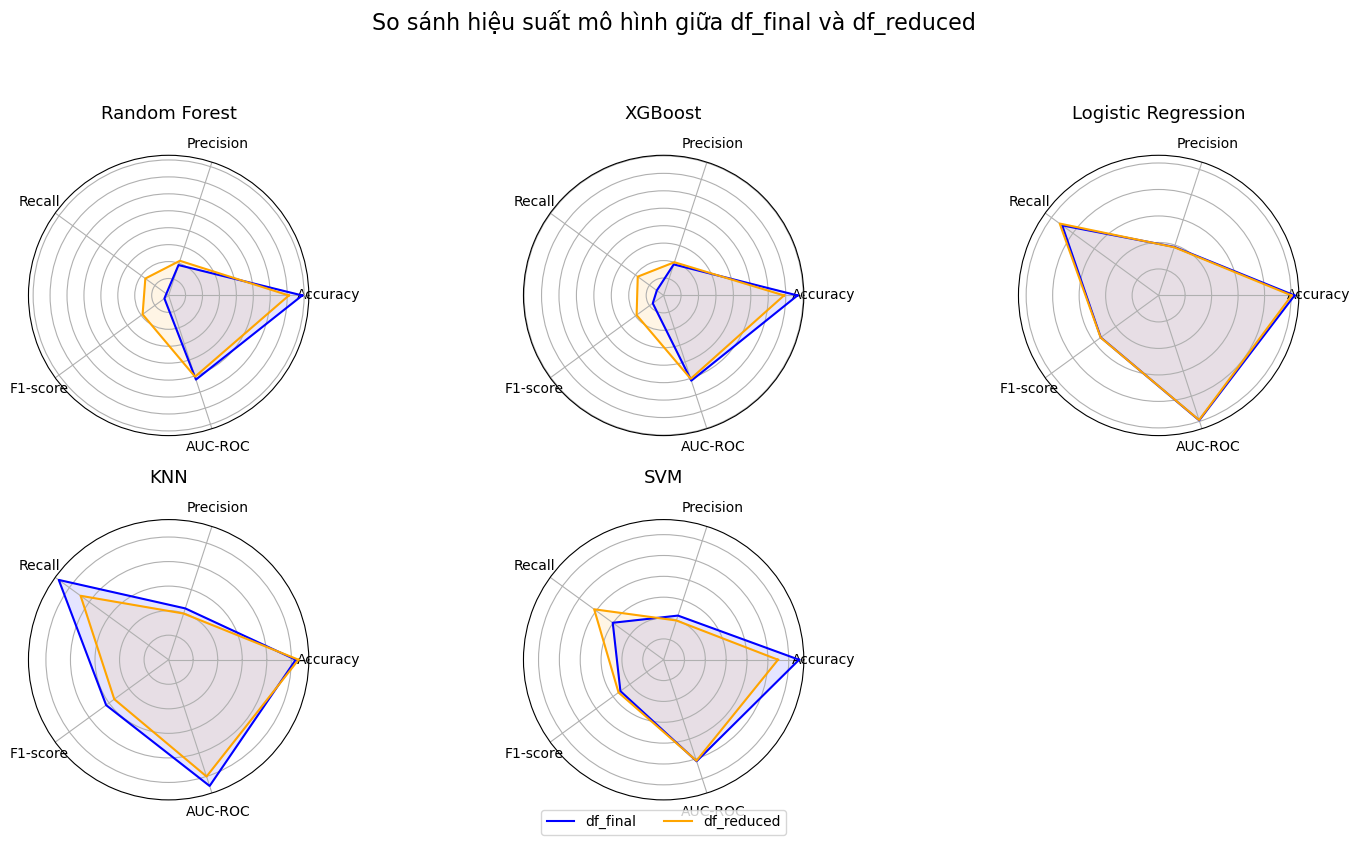

In [12]:
import matplotlib.pyplot as plt
# Các chỉ số muốn hiển thị
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC-ROC']
num_vars = len(metrics)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # khép kín hình

# Hàm vẽ biểu đồ radar cho từng mô hình
def plot_model_radar(ax, model_name):
    data_final = results_df[(results_df['Model'] == model_name) & (results_df['Dataset'] == 'df_final')]
    data_reduced = results_df[(results_df['Model'] == model_name) & (results_df['Dataset'] == 'df_reduced')]

    if data_final.empty or data_reduced.empty:
        print(f"Bỏ qua {model_name} do thiếu dữ liệu.")
        return

    values_final = data_final[metrics].values.flatten().tolist()
    values_reduced = data_reduced[metrics].values.flatten().tolist()

    values_final += values_final[:1]
    values_reduced += values_reduced[:1]

    ax.plot(angles, values_final, label='df_final', color='blue')
    ax.fill(angles, values_final, alpha=0.1, color='blue')

    ax.plot(angles, values_reduced, label='df_reduced', color='orange')
    ax.fill(angles, values_reduced, alpha=0.1, color='orange')

    ax.set_title(model_name, size=13, y=1.1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics)
    ax.set_yticklabels([])
    ax.grid(True)

# Lấy danh sách các mô hình
models = results_df['Model'].unique()
num_models = len(models)

# Thiết lập layout cho biểu đồ radar
cols = 3
rows = int(np.ceil(num_models / cols))
fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), subplot_kw=dict(polar=True))
axs = axs.flatten()

# Vẽ biểu đồ cho từng mô hình
for i, model in enumerate(models):
    plot_model_radar(axs[i], model)

# Xoá ô trống nếu có
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Thêm chú thích
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.suptitle("So sánh hiệu suất mô hình giữa df_final và df_reduced", y=1.05, fontsize=16)
plt.tight_layout()
plt.show()


### Lựa chọn mô hình

In [13]:

import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix
from imblearn.over_sampling import ADASYN
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler
import os

# Đảm bảo thư mục model/ tồn tại
os.makedirs('model', exist_ok=True)

# Chuẩn bị dữ liệu
numeric_columns = [
    'Age', 'Sleep Hours', 'BMI', 'Homocysteine Level', 'Cholesterol Level',
    'Blood Pressure', 'Triglyceride Level', 'CRP Level', 'Fasting Blood Sugar'
]
all_columns = ['Stress Level'] + numeric_columns + ['Heart Disease Status']

# Chuyển DataFrame thành NumPy array
X = df_reduced_copy[all_columns[:-1]].values
y = df_reduced_copy['Heart Disease Status'].values

# Debug: Kiểm tra phân phối dữ liệu gốc
print("Phân phối nhãn trong dữ liệu gốc:\n", pd.Series(y).value_counts(normalize=True) * 100)
print("Thống kê dữ liệu gốc:\n", df_reduced_copy[all_columns[:-1]].describe())

# Chuẩn hóa dữ liệu số
scaler_standard = StandardScaler()
X[:, 1:10] = scaler_standard.fit_transform(X[:, 1:10])
print("Scaler mean:", scaler_standard.mean_)
print("Scaler scale:", scaler_standard.scale_)

# Áp dụng ADASYN để cân bằng dữ liệu
adasyn = ADASYN(random_state=42)
X_balanced, y_balanced = adasyn.fit_resample(X, y)
print("Phân phối nhãn sau ADASYN:\n", pd.Series(y_balanced).value_counts(normalize=True) * 100)

# Chia train/test
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42,stratify=y_balanced)

# Tối ưu hóa Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10]
}
rf = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(rf, rf_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_
print("Best Random Forest Parameters:", grid_search_rf.best_params_)
print("Best Random Forest Accuracy:", grid_search_rf.best_score_)

# Tối ưu hóa XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7]
}
xgb_model = xgb.XGBClassifier(eval_metric='logloss')
grid_search_xgb = GridSearchCV(xgb_model, xgb_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)
best_xgb = grid_search_xgb.best_estimator_
print("Best XGBoost Parameters:", grid_search_xgb.best_params_)
print("Best XGBoost Accuracy:", grid_search_xgb.best_score_)

# Tối ưu hóa LightGBM

lgbm_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'num_leaves': [20, 31, 40]
}
lgbm_model = LGBMClassifier(random_state=42, verbose=-1)
grid_search_lgbm = GridSearchCV(lgbm_model, lgbm_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_lgbm.fit(X_train, y_train)
best_lgbm = grid_search_lgbm.best_estimator_
print("Best LightGBM Parameters:", grid_search_lgbm.best_params_)
print("Best LightGBM Accuracy:", grid_search_lgbm.best_score_)

# Tối ưu hóa Logistic Regression
logreg_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],     # Điều chỉnh mức phạt regularization
    'penalty': ['l2'],                # L1 có thể dùng nếu solver là 'liblinear'
    'solver': ['lbfgs'],              # Tối ưu cho L2 và phù hợp dữ liệu lớn
    'max_iter': [1000]                # Đảm bảo hội tụ
}

logreg_model = LogisticRegression(random_state=42)
grid_search_logreg = GridSearchCV(logreg_model, logreg_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_logreg.fit(X_train, y_train)
best_logreg = grid_search_logreg.best_estimator_

print("\nBest Logistic Regression Parameters:", grid_search_logreg.best_params_)
print("Best Logistic Regression Accuracy:", grid_search_logreg.best_score_)

# Đánh giá từng mô hình trên tập test
models = [('Random Forest', best_rf), ('XGBoost', best_xgb), ('LightGBM', best_lgbm), ('Logistic Regression', best_logreg)]
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    print(f"\nĐánh giá {name}:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("AUC-ROC:", roc_auc_score(y_test, y_pred_proba))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))




Phân phối nhãn trong dữ liệu gốc:
 0    80.0
1    20.0
Name: proportion, dtype: float64
Thống kê dữ liệu gốc:
        Stress Level           Age   Sleep Hours           BMI  \
count  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.497600     49.292000      6.991143     29.078752   
std        0.406092     18.172167      1.751334      6.301482   
min        0.000000     18.000000      4.000605     18.002837   
25%        0.000000     34.000000      5.452257     23.668887   
50%        0.500000     49.000000      7.002959     29.085885   
75%        1.000000     65.000000      8.527938     34.509346   
max        1.000000     80.000000      9.999952     39.996954   

       Homocysteine Level  Cholesterol Level  Blood Pressure  \
count        10000.000000       10000.000000    10000.000000   
mean            12.457107         225.441580      149.756660   
std              4.320174          43.520147       17.557947   
min              5.000236         150.000000   

Best threshold: 0.36
Recall at this threshold: 0.91
Precision at this threshold: 0.74
F1-score at this threshold: 0.81


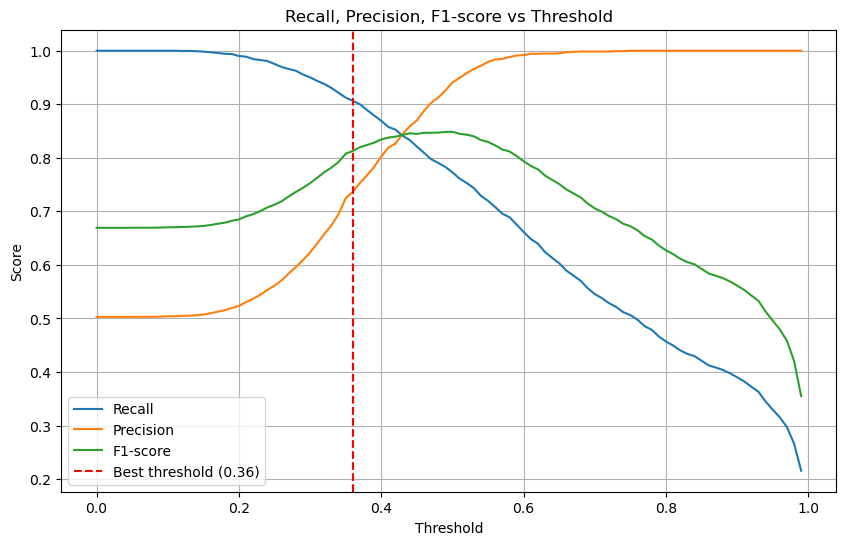

In [15]:

from sklearn.metrics import recall_score, precision_score, f1_score
import matplotlib.pyplot as plt

# Dự đoán xác suất nhãn 1
y_proba = best_rf.predict_proba(X_test)[:, 1]

# Kiểm tra recall, precision, F1 cho nhãn 1 tại các ngưỡng
thresholds = np.arange(0.0, 1.0, 0.01)
recall_values = []
precision_values = []
f1_values = []

for threshold in thresholds:
    y_pred_new = (y_proba >= threshold).astype(int)
    recall = recall_score(y_test, y_pred_new, pos_label=1, zero_division=0)
    precision = precision_score(y_test, y_pred_new, pos_label=1, zero_division=0)
    f1 = f1_score(y_test, y_pred_new, pos_label=1, zero_division=0)
    recall_values.append(recall)
    precision_values.append(precision)
    f1_values.append(f1)

# Tìm ngưỡng tối ưu (ưu tiên recall cao, nhưng precision không quá thấp)
# Ví dụ: chọn ngưỡng có recall >= 0.9 và F1-score cao nhất
best_idx = np.argmax([f1 if r >= 0.9 else -1 for r, f1 in zip(recall_values, f1_values)])
best_threshold = thresholds[best_idx]
best_recall = recall_values[best_idx]
best_precision = precision_values[best_idx]
best_f1 = f1_values[best_idx]

print(f"Best threshold: {best_threshold:.2f}")
print(f"Recall at this threshold: {best_recall:.2f}")
print(f"Precision at this threshold: {best_precision:.2f}")
print(f"F1-score at this threshold: {best_f1:.2f}")

# Vẽ biểu đồ recall, precision theo ngưỡng
plt.figure(figsize=(10, 6))
plt.plot(thresholds, recall_values, label='Recall')
plt.plot(thresholds, precision_values, label='Precision')
plt.plot(thresholds, f1_values, label='F1-score')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best threshold ({best_threshold:.2f})')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Recall, Precision, F1-score vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
# Dự đoán xác suất trên tập test 
y_proba = best_rf.predict_proba(X_test)[:, 1]

# Áp dụng ngưỡng 0.36
y_pred = (y_proba >= 0.36).astype(int)

from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, classification_report

# Đánh giá
recall = recall_score(y_test, y_pred, pos_label=1)
precision = precision_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)
accuracy = accuracy_score(y_test, y_pred)

print(f"Threshold: 0.36")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1-score: {f1:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Threshold: 0.36
Recall: 0.91
Precision: 0.74
F1-score: 0.81
Accuracy: 0.79

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.67      0.76      2400
           1       0.74      0.91      0.81      2429

    accuracy                           0.79      4829
   macro avg       0.81      0.79      0.79      4829
weighted avg       0.81      0.79      0.79      4829



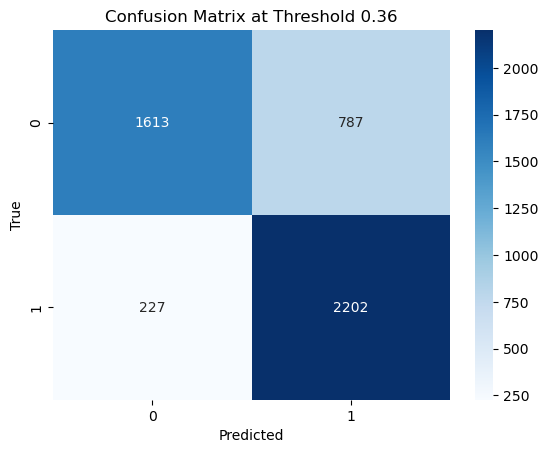

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix at Threshold 0.36')
plt.show()

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import ADASYN
from sklearn.metrics import recall_score, precision_score, f1_score, classification_report, confusion_matrix
from sklearn.utils import resample
import joblib
import os
import json

# Đảm bảo thư mục model/ tồn tại
os.makedirs('model', exist_ok=True)

# Chuẩn bị dữ liệu
numeric_columns = [
    'Age', 'Sleep Hours', 'BMI', 'Homocysteine Level', 'Cholesterol Level',
    'Blood Pressure', 'Triglyceride Level', 'CRP Level', 'Fasting Blood Sugar'
]
all_columns = ['Stress Level'] + numeric_columns + ['Heart Disease Status']
X_columns = all_columns[:-1]

# Lưu danh sách cột đặc trưng
np.save('model/X_columns.npy', X_columns)
print("Đã lưu danh sách cột đặc trưng vào 'model/X_columns.npy':", X_columns)

# Upsample mẫu nhãn 1 nguy cơ cao và trung bình
high_risk_1 = df_reduced_copy[
    (df_reduced_copy['Heart Disease Status'] == 1) &
    ((df_reduced_copy['Cholesterol Level'] >= 200.0) |
     (df_reduced_copy['Triglyceride Level'] >= 200.0) |
     (df_reduced_copy['CRP Level'] >= 3.0) |
     (df_reduced_copy['Blood Pressure'] >= 140.0) |
     (df_reduced_copy['Age'] >= 65.0))
]
high_risk_1_upsampled = resample(high_risk_1, replace=True, n_samples=500, random_state=42)  # Giảm từ 1000 xuống 500
df_upsampled = pd.concat([df_reduced_copy, high_risk_1_upsampled])
print("Số mẫu sau khi upsample:", len(df_upsampled))
print("Phân bố nhãn sau upsample:\n", df_upsampled['Heart Disease Status'].value_counts())

# Chuyển DataFrame thành NumPy array
X = df_upsampled[all_columns[:-1]].values
y = df_upsampled['Heart Disease Status'].values

# Kiểm tra thống kê dữ liệu
print("Thống kê dữ liệu sau upsample:\n", df_upsampled[all_columns[:-1]].describe())

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X[:, 1:] = scaler.fit_transform(X[:, 1:])
joblib.dump(scaler, 'model/scaler.pkl')
print("Scaler mean:", scaler.mean_)
print("Scaler scale:", scaler.scale_)
print("Đã lưu StandardScaler vào 'model/scaler.pkl'")

# Áp dụng ADASYN
# Đếm số mẫu nhãn 0 và nhãn 1
n_samples_0 = np.sum(y == 0)
n_samples_1 = np.sum(y == 1)
adasyn = ADASYN(sampling_strategy={0: n_samples_0, 1: int(n_samples_0 * 0.8)}, random_state=42)  # Nhãn 1 = 80% nhãn 0
X_balanced, y_balanced = adasyn.fit_resample(X, y)
print("Phân bố nhãn sau ADASYN:\n", pd.Series(y_balanced).value_counts())

# Chia train/test
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced)

# Huấn luyện Random Forest
best_rf = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=5, 
                                 class_weight={0:1, 1:3}, random_state=42)  # Giảm từ 1:5 xuống 1:3
best_rf.fit(X_train, y_train)

# Lưu mô hình
joblib.dump(best_rf, 'model/random_forest_model.pkl')
print("Đã lưu mô hình Random Forest vào 'model/random_forest_model.pkl'")

# Đánh giá với ngưỡng 0.36
threshold = 0.36
y_proba = best_rf.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= threshold).astype(int)

print(f"\nĐánh giá Random Forest tại ngưỡng {threshold}:")
print("Recall (nhãn 1):", recall_score(y_test, y_pred, pos_label=1))
print("Precision (nhãn 1):", precision_score(y_test, y_pred, pos_label=1))
print("F1-score (nhãn 1):", f1_score(y_test, y_pred, pos_label=1))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Lưu ngưỡng
with open('model/threshold.json', 'w') as f:
    json.dump({'threshold': threshold}, f, indent=4)
print("Đã lưu ngưỡng phân loại vào 'model/threshold.json'")


Đã lưu danh sách cột đặc trưng vào 'model/X_columns.npy': ['Stress Level', 'Age', 'Sleep Hours', 'BMI', 'Homocysteine Level', 'Cholesterol Level', 'Blood Pressure', 'Triglyceride Level', 'CRP Level', 'Fasting Blood Sugar']
Số mẫu sau khi upsample: 10500
Phân bố nhãn sau upsample:
 Heart Disease Status
0    8000
1    2500
Name: count, dtype: int64
Thống kê dữ liệu sau upsample:
        Stress Level           Age   Sleep Hours           BMI  \
count  10500.000000  10500.000000  10500.000000  10500.000000   
mean       0.498095     49.271600      6.986292     29.101586   
std        0.405513     18.129544      1.751425      6.303040   
min        0.000000     18.000000      4.000605     18.002837   
25%        0.000000     34.000000      5.449616     23.687737   
50%        0.500000     49.000000      7.000719     29.137070   
75%        1.000000     65.000000      8.520973     34.533315   
max        1.000000     80.000000      9.999952     39.996954   

       Homocysteine Level  Choles